In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Loading

In [2]:
annot_files = glob.glob('../brazil_whale_audios_new/selections/*.txt')

In [3]:
name_click = 'Click'
name_whistle = 'Whistle'

In [4]:
df_list = []
for file in annot_files:
    tmp_df = pd.read_csv(file, sep='\t')
    start_time = file.split('.')[2].split('_')[-3:]
    start_time = pd.to_datetime(''.join(start_time), format='%Y%m%d%H%M%S%f')
    tmp_df['start_time'] = start_time
    tmp_df = tmp_df.drop(columns=['Selection', 'View'])
    tmp_df['rec_type'] = file.split('/')[-1].split('_')[0][:3]
    tmp_df['file_name'] = file.split('/')[-1].split('.')[0]
    tmp_df = tmp_df.rename(columns={'Type': 'type'})
    if 'type' not in tmp_df.columns:
        print(f'file {file} doesnt have any type')
        continue
    # Fix spelling errors
    click_missplelings = ['Clck', 'Clikes', 'Cliks', 'click', 'Cliks', 'lick',
                          'Cick', 'Clcik', 'Click ']
    tmp_df['type'] = tmp_df['type'].replace(dict(zip(click_missplelings,
                                                     [name_click] * len(click_missplelings))))
    tmp_df['type'] = tmp_df['type'].replace({'Whidtle': name_whistle, 'whistle': name_whistle,
                                             'Whistlr': name_whistle})
    df_list.append(tmp_df)

In [5]:
annot_df = pd.concat(df_list, axis=0)

In [6]:
annot_df.head(2)

,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),type,start_time,rec_type,file_name
0,4,0.057350,1.010800,27354.8,46709.7,Click,2017-08-04 08:43:50.893,LPS,LPS1142017_MF_20170804_084350_893
1,4,13.022126,14.326847,29677.4,46193.5,Click,2017-08-04 08:43:50.893,LPS,LPS1142017_MF_20170804_084350_893


# Exploration

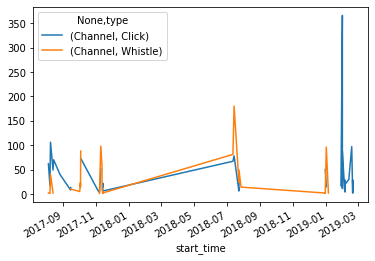

In [7]:
annot_df[['type', 'start_time', 'Channel']].groupby(['start_time', 'type']).count().unstack('type').plot()
plt.show()

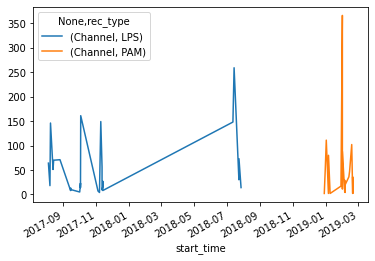

In [8]:
annot_df[['rec_type', 'start_time', 'Channel']].groupby(['start_time', 'rec_type']).count().unstack('rec_type').plot()
plt.show()

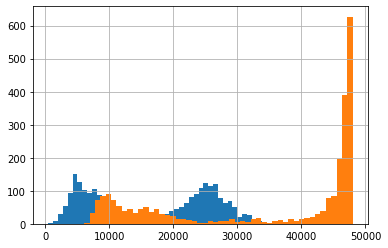

In [9]:
annot_df["Low Freq (Hz)"].hist(bins=50)
annot_df["High Freq (Hz)"].hist(bins=50)
plt.show()

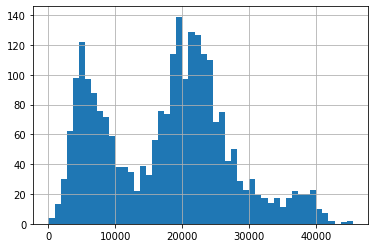

In [10]:
(annot_df["High Freq (Hz)"] - annot_df["Low Freq (Hz)"]).hist(bins=50)
plt.show()

In [12]:
annot_df['Low Freq (Hz)'].min()

493.6

In [15]:
import seaborn as sns

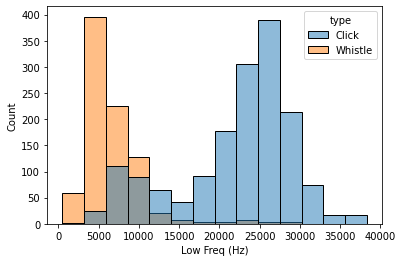

In [16]:
sns.histplot(annot_df[['Low Freq (Hz)', 'type', 'High Freq (Hz)']].reset_index(drop=True), x='Low Freq (Hz)', hue='type')
plt.show()

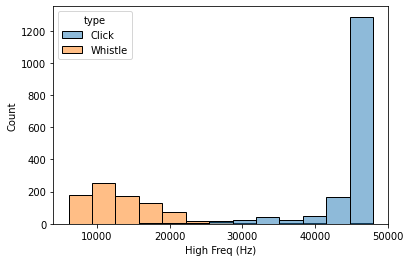

In [17]:
sns.histplot(annot_df[['Low Freq (Hz)', 'type', 'High Freq (Hz)']].reset_index(drop=True), x='High Freq (Hz)', hue='type')
plt.show()

### Explore length of calls 

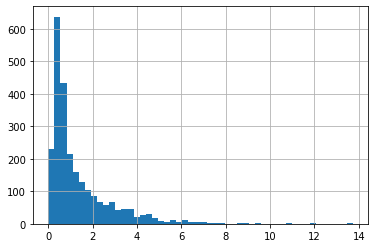

In [18]:
(annot_df["End Time (s)"] - annot_df["Begin Time (s)"]).hist(bins=50)
plt.show()

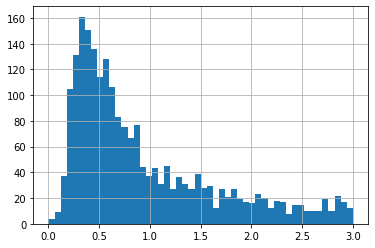

In [19]:
(annot_df["End Time (s)"] - annot_df["Begin Time (s)"]).hist(bins=50, range=(0, 3))
plt.show()

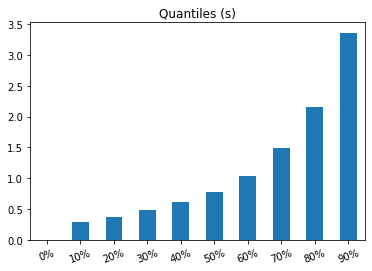

In [20]:
quantile_keys = np.arange(0, 1, 0.1)
pd.Series(np.quantile(annot_df["End Time (s)"] - annot_df["Begin Time (s)"], quantile_keys), index=map(lambda x: f'{x:.0%}', quantile_keys), name='Quantiles').plot.bar()
plt.title('Quantiles (s)')
plt.xticks(rotation=20)
plt.show()

# Create model annotations

begin_time, end_time, channel, filename, call_length, label

In [21]:
import itertools

def range_diff(r1, r2):
    s1, e1 = r1
    s2, e2 = r2
    endpoints = sorted((s1, s2, e1, e2))
    result = []
    if endpoints[0] == s1 and endpoints[1] != s1:
        result.append((endpoints[0], endpoints[1]))
    if endpoints[3] == e1 and endpoints[2] != e1:
        result.append((endpoints[2], endpoints[3]))
    return result

def multirange_diff(r1_list, r2_list):
    """Generated the difference between two time ranges"""
    for r2 in r2_list:
        r1_list = list(itertools.chain(*[range_diff(r1, r2) for r1 in r1_list]))
    return r1_list

In [22]:
import soundfile as sf

In [23]:
wav_folder = '../brazil_whale_audios_new/'

In [24]:
audio_files = annot_df.file_name.unique()

In [25]:
model_file_list = []
for file in audio_files:
    file_length = sf.info(wav_folder + file + '.wav').duration
    relevant_annot = annot_df[annot_df.file_name == file]
    model_annot_file = relevant_annot.copy()
    model_annot_file.drop(columns=['Low Freq (Hz)', 'High Freq (Hz)', 'rec_type', 'start_time'], inplace=True)
    model_annot_file.rename(columns={'Channel': 'channel', 'Begin Time (s)': 'begin_time', 'End Time (s)': 'end_time', 'file_name': 'filename'}, inplace=True)
    
    # Background is the subtraction of the annotated sections from the whole timerange in the file 
    bg_ranges = np.array(multirange_diff([(0, file_length)], [(relevant_annot['Begin Time (s)'][i], relevant_annot['End Time (s)'][i]) for i in range(len(relevant_annot))])).astype(float)
    
    # Noise exists in all channels, signal exists only in the channel it was annotated in
    for ch in range(1, 5):
        bg_annot = pd.DataFrame(np.array([ch * np.ones(len(bg_ranges), int), bg_ranges[:, 0], bg_ranges[:, 1], ['Noise'] * len(bg_ranges), [file] * len(bg_ranges)]).T,
                           columns=model_annot_file.columns)
        model_annot_file = pd.concat([model_annot_file, bg_annot], axis=0, ignore_index=True)
    model_annot_file['begin_time'] = model_annot_file['begin_time'].astype(float)
    model_annot_file['end_time'] = model_annot_file['end_time'].astype(float)
    model_annot_file = model_annot_file.sort_values('begin_time')
    model_file_list.append(model_annot_file)

In [26]:
model_annot_all_df = pd.concat(model_file_list, axis=0, ignore_index=True)

In [27]:
model_annot_all_df['call_length'] = model_annot_all_df['end_time'] - model_annot_all_df['begin_time']

In [28]:
# There are some NaN calls. We don't want them in either call or noise
model_annot_all_df.dropna(inplace=True)

In [29]:
model_annot_all_df['label'] = model_annot_all_df['type'].replace({'Noise': 0, name_click: 1, name_whistle: 1}).astype(int)

In [30]:
model_annot_all_df.drop(columns=['type'], inplace=True)

In [31]:
model_annot_all_df.head(2)

,channel,begin_time,end_time,filename,call_length,label
0,3,0.0,0.05735,LPS1142017_MF_20170804_084350_893,0.05735,0
1,2,0.0,0.05735,LPS1142017_MF_20170804_084350_893,0.05735,0


## Test out the annotations (what sections of files are annotated?)

In [32]:
model_annot_all_df.label.value_counts()

0    7064
1    2479
Name: label, dtype: int64

In [33]:
tmp_df = model_annot_all_df[['channel', 'begin_time', 'end_time', 'label', 'filename']
                  ].groupby(['begin_time', 'end_time', 'filename']).agg(
                                           label=('label', 'max')
                  ).reset_index().sort_values(['filename', 'begin_time']
                   ).set_index(['filename', 'label'])

/home/noam/venv/whale/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


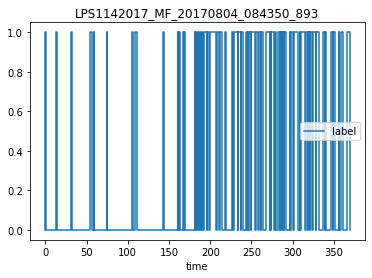

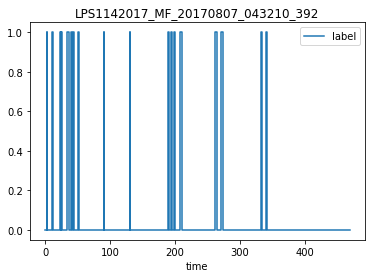

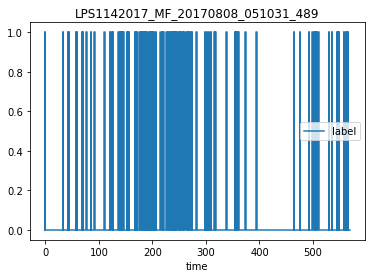

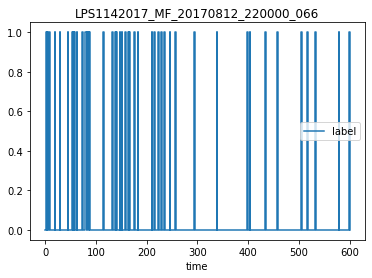

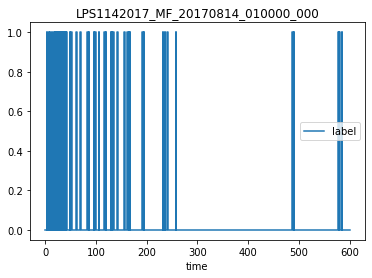

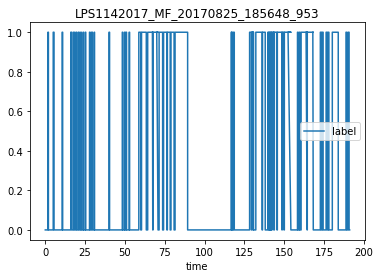

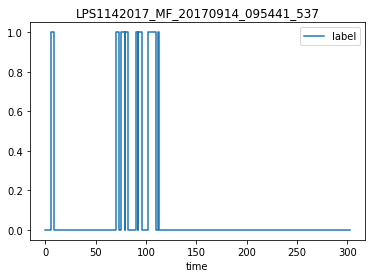

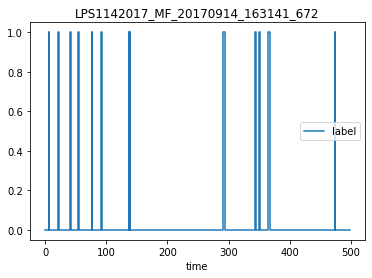

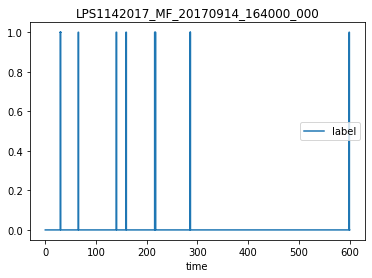

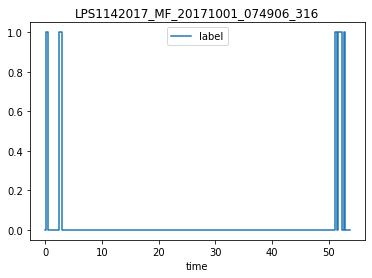

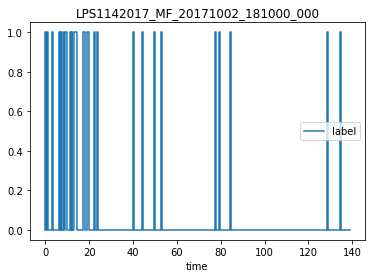

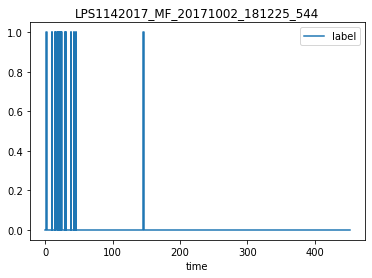

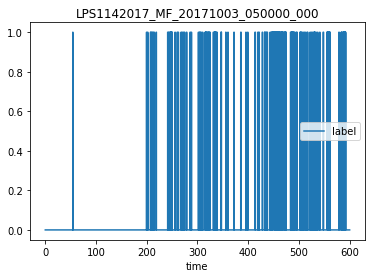

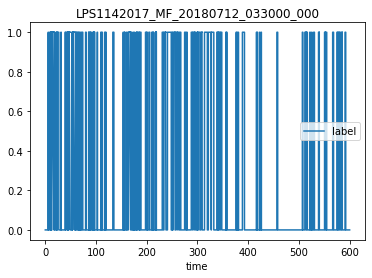

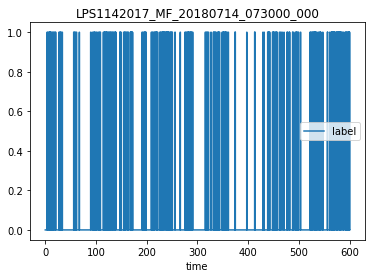

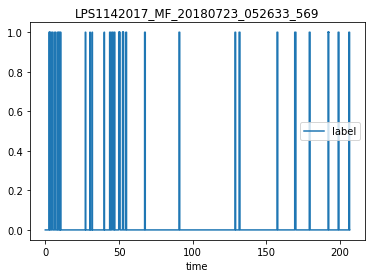

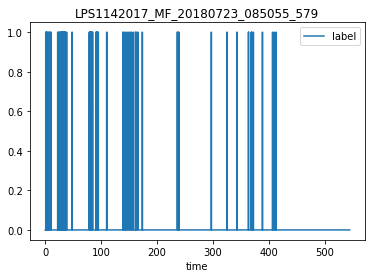

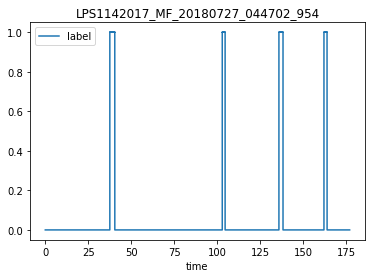

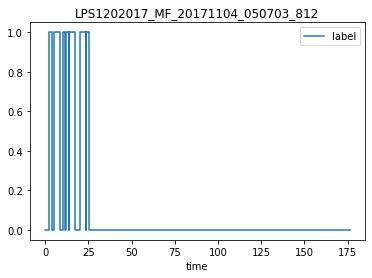

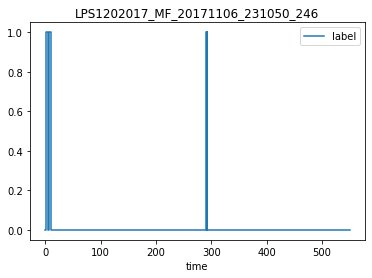

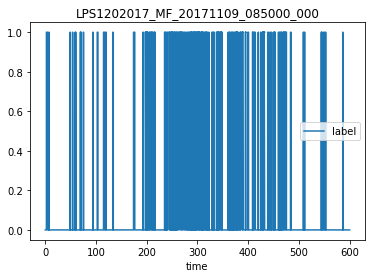

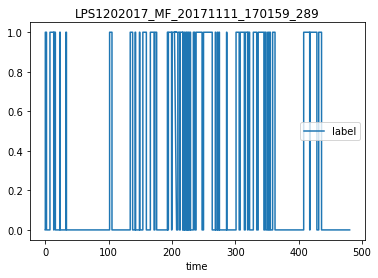

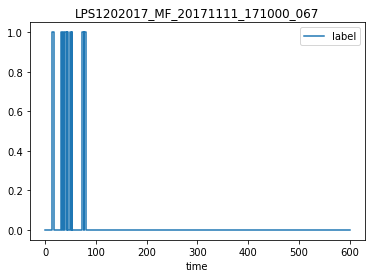

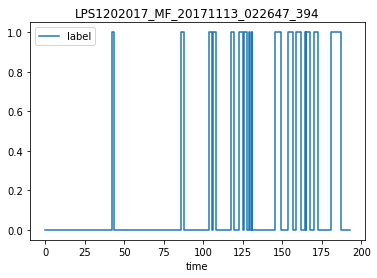

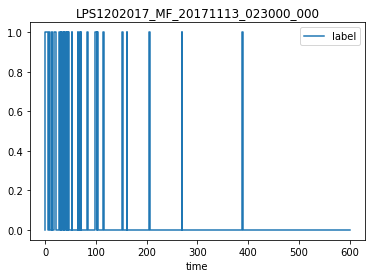

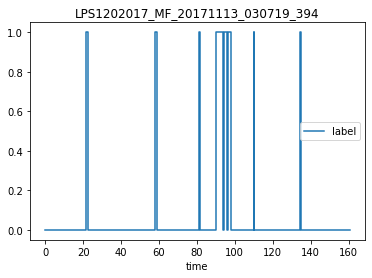

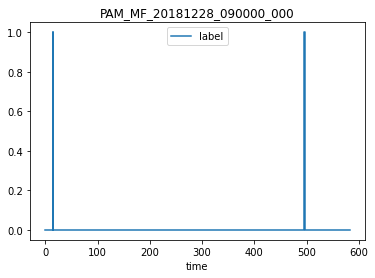

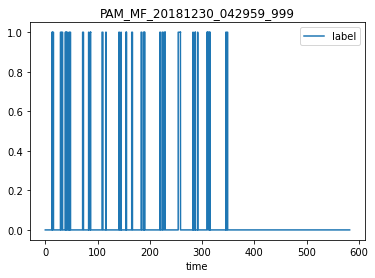

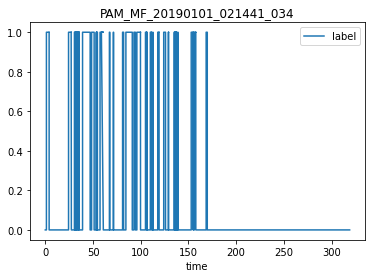

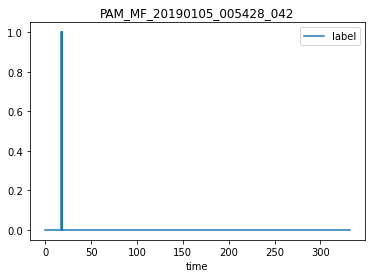

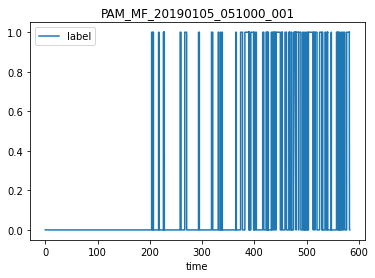

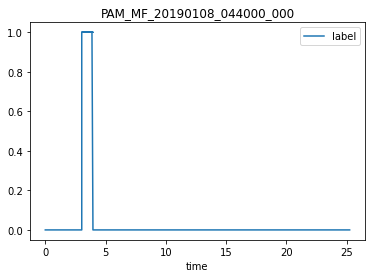

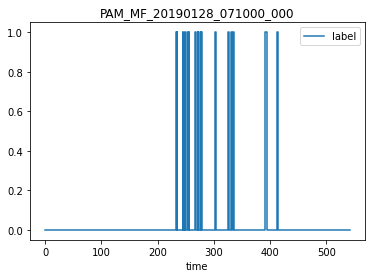

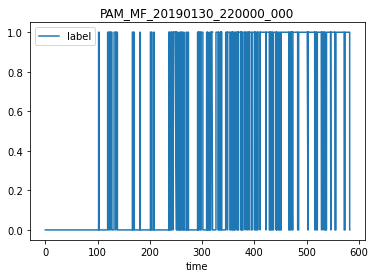

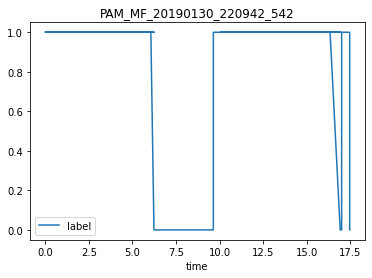

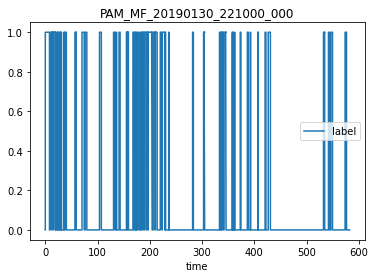

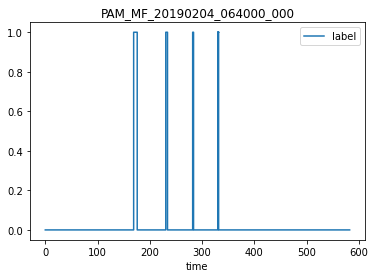

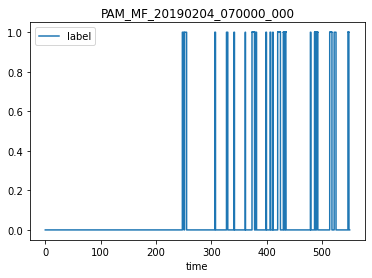

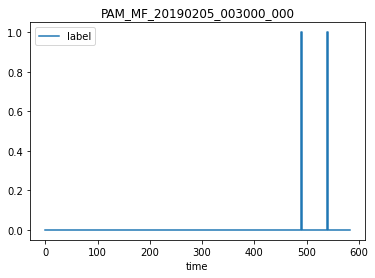

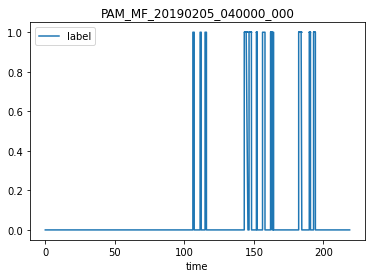

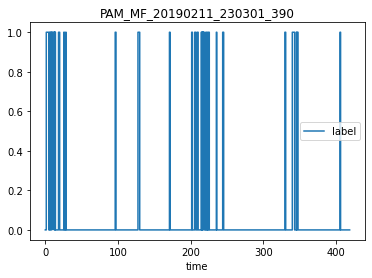

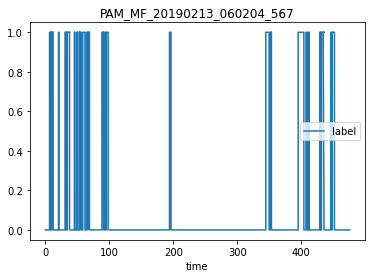

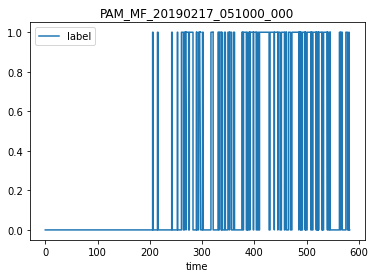

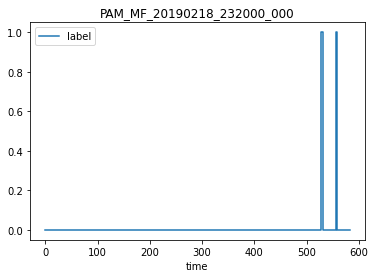

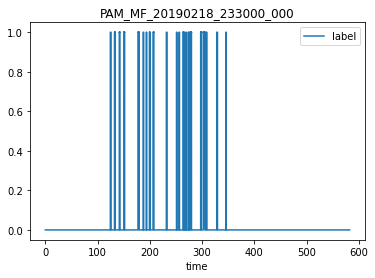

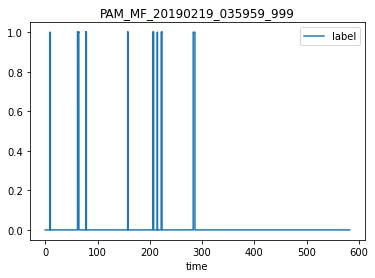

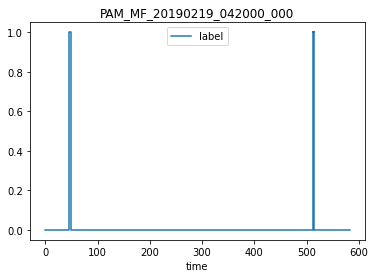

In [34]:
for file in tmp_df.index.get_level_values(0).unique():
    tmp_df.loc[file, :].stack().reset_index(
        ).drop(['level_1'], axis=1).rename(columns = {0: 'time'}
                                                      ).set_index('time').plot(title=file)

## Filter calls that are too short

In [48]:
pd.Series(np.quantile(annot_df["End Time (s)"] - annot_df["Begin Time (s)"], quantile_keys), index=map(lambda x: f'{x:.0%}', quantile_keys), name='Quantiles')

0%     0.000000
10%    0.284091
20%    0.379028
30%    0.484065
40%    0.608447
50%    0.780769
60%    1.044410
70%    1.484466
80%    2.164691
90%    3.362466
Name: Quantiles, dtype: float64

In [49]:
model_annot_all_df = model_annot_all_df[(model_annot_all_df['call_length'] > 0.3)]

## Split

In [50]:
annot_w_len_df = annot_df.copy()
annot_w_len_df['len'] = annot_w_len_df['End Time (s)'] - annot_w_len_df['Begin Time (s)']

In [51]:
annot_w_len_df[annot_w_len_df.rec_type=='LPS'][['file_name', 'start_time', 'len']].groupby(['start_time', 'file_name']).sum().sort_index().cumsum() / annot_w_len_df[annot_w_len_df.rec_type=='LPS']['len'].sum()

,,len
start_time,file_name,
2017-08-04 08:43:50.893,LPS1142017_MF_20170804_084350_893,0.097499
2017-08-07 04:32:10.392,LPS1142017_MF_20170807_043210_392,0.118198
2017-08-08 05:10:31.489,LPS1142017_MF_20170808_051031_489,0.169052
2017-08-12 22:00:00.066,LPS1142017_MF_20170812_220000_066,0.209806
2017-08-14 01:00:00.000,LPS1142017_MF_20170814_010000_000,0.233892
2017-08-25 18:56:48.953,LPS1142017_MF_20170825_185648_953,0.289721
2017-09-14 09:54:41.537,LPS1142017_MF_20170914_095441_537,0.309348
2017-09-14 16:31:41.672,LPS1142017_MF_20170914_163141_672,0.323545
2017-09-14 16:40:00.000,LPS1142017_MF_20170914_164000_000,0.327902


In [52]:
test_files = ['LPS1142017_MF_20180727_044702_954', 'LPS1142017_MF_20180723_085055_579', 'LPS1142017_MF_20180723_052633_569', 'LPS1142017_MF_20180714_073000_000']
val_files = ['LPS1202017_MF_20171113_030719_394', 'LPS1202017_MF_20171113_023000_000', 'LPS1202017_MF_20171113_022647_394', 'LPS1202017_MF_20171111_171000_067']

In [53]:
annot_w_len_df[(annot_w_len_df.rec_type=='LPS') & (annot_w_len_df.file_name.isin(test_files))]['len'].sum() / (annot_w_len_df[annot_df.rec_type=='LPS']['len'].sum())

0.15738463529565322

In [54]:
annot_w_len_df[(annot_w_len_df.rec_type=='LPS') & (annot_w_len_df.file_name.isin(val_files))]['len'].sum() / (annot_w_len_df[annot_df.rec_type=='LPS']['len'].sum())

0.08371666983310748

In [55]:
annot_w_len_df[annot_w_len_df.rec_type=='PAM'][['file_name', 'start_time', 'len']].groupby(['start_time', 'file_name']).sum().sort_index().cumsum() / annot_w_len_df[annot_w_len_df.rec_type=='PAM']['len'].sum()

,,len
start_time,file_name,
2018-12-28 09:00:00.000,PAM_MF_20181228_090000_000,0.001033
2018-12-30 04:29:59.999,PAM_MF_20181230_042959_999,0.027173
2019-01-01 02:14:41.034,PAM_MF_20190101_021441_034,0.066148
2019-01-05 00:54:28.042,PAM_MF_20190105_005428_042,0.066831
2019-01-05 05:10:00.001,PAM_MF_20190105_051000_001,0.150428
2019-01-08 04:40:00.000,PAM_MF_20190108_044000_000,0.151296
2019-01-28 07:10:00.000,PAM_MF_20190128_071000_000,0.162021
2019-01-30 22:00:00.000,PAM_MF_20190130_220000_000,0.589883
2019-01-30 22:09:42.542,PAM_MF_20190130_220942_542,0.605691


In [56]:
test_files.extend(['PAM_MF_20190219_042000_000', 'PAM_MF_20190219_035959_999', 'PAM_MF_20190218_233000_000', 'PAM_MF_20190218_232000_000', 'PAM_MF_20190217_051000_000', 'PAM_MF_20190213_060204_567'])

In [57]:
annot_w_len_df[(annot_w_len_df.rec_type=='PAM') & (annot_w_len_df.file_name.isin(test_files))]['len'].sum() / (annot_w_len_df[annot_df.rec_type=='PAM']['len'].sum())

0.23581165748779945

In [58]:
val_files.extend(['PAM_MF_20190211_230301_390', 'PAM_MF_20190205_040000_000', 'PAM_MF_20190205_003000_000', 'PAM_MF_20190204_070000_000', 'PAM_MF_20190204_064000_000', 'PAM_MF_20190130_221000_000'])

In [59]:
annot_w_len_df[(annot_w_len_df.rec_type=='PAM') & (annot_w_len_df.file_name.isin(val_files))]['len'].sum() / (annot_w_len_df[annot_df.rec_type=='PAM']['len'].sum())

0.15849743414600587

In [60]:
assert len(set(val_files).intersection(set(test_files))) == 0

In [61]:
val_files

['LPS1202017_MF_20171113_030719_394',
 'LPS1202017_MF_20171113_023000_000',
 'LPS1202017_MF_20171113_022647_394',
 'LPS1202017_MF_20171111_171000_067',
 'PAM_MF_20190211_230301_390',
 'PAM_MF_20190205_040000_000',
 'PAM_MF_20190205_003000_000',
 'PAM_MF_20190204_070000_000',
 'PAM_MF_20190204_064000_000',
 'PAM_MF_20190130_221000_000']

In [62]:
model_annot_train_df = model_annot_all_df[~model_annot_all_df.filename.isin(val_files + test_files)]
model_annot_val_df = model_annot_all_df[model_annot_all_df.filename.isin(val_files)]
model_annot_test_df = model_annot_all_df[model_annot_all_df.filename.isin(test_files)]

In [63]:
model_annot_train_df['call_length'].sum()

41743.09944623566

In [64]:
model_annot_train_df[['call_length', 'label']].groupby('label').sum() / model_annot_train_df['call_length'].sum()

,call_length
label,
0,0.947009
1,0.052991


In [65]:
model_annot_val_df['call_length'].sum()

16969.124811736998

In [66]:
model_annot_val_df[['call_length', 'label']].groupby('label').sum() / model_annot_val_df['call_length'].sum()

,call_length
label,
0,0.9744
1,0.0256


In [67]:
model_annot_test_df['call_length'].sum()

18352.642952008002

In [68]:
model_annot_test_df[['call_length', 'label']].groupby('label').sum() / model_annot_test_df['call_length'].sum()

,call_length
label,
0,0.96289
1,0.03711


In [69]:
model_annot_train_df.to_csv('../soundbay/datasets/brazil/annotation_train.csv', index=False)
model_annot_val_df.to_csv('../soundbay/datasets/brazil/annotation_val.csv', index=False)
model_annot_test_df.to_csv('../soundbay/datasets/brazil/annotation_test.csv', index=False)

# Create model annotations Whistles only are 1

begin_time, end_time, channel, filename, call_length, label

In [96]:
import itertools

def range_diff(r1, r2):
    s1, e1 = r1
    s2, e2 = r2
    endpoints = sorted((s1, s2, e1, e2))
    result = []
    if endpoints[0] == s1 and endpoints[1] != s1:
        result.append((endpoints[0], endpoints[1]))
    if endpoints[3] == e1 and endpoints[2] != e1:
        result.append((endpoints[2], endpoints[3]))
    return result

def multirange_diff(r1_list, r2_list):
    for r2 in r2_list:
        r1_list = list(itertools.chain(*[range_diff(r1, r2) for r1 in r1_list]))
    return r1_list

In [97]:
import soundfile as sf

In [72]:
wav_folder = '../brazil_whale_audios_new/'

In [73]:
audio_files = annot_df.file_name.unique()

In [74]:
model_file_list = []
for file in audio_files:
    file_length = sf.info(wav_folder + file + '.wav').duration
    relevant_annot = annot_df[annot_df.file_name == file]
    model_annot_file = relevant_annot.copy()
    model_annot_file.drop(columns=['Low Freq (Hz)', 'High Freq (Hz)', 'rec_type', 'start_time'], inplace=True)
    model_annot_file.rename(columns={'Channel': 'channel', 'Begin Time (s)': 'begin_time', 'End Time (s)': 'end_time', 'file_name': 'filename'}, inplace=True)
    
    # Background is the subtraction of the annotated sections from the whole timerange in the file 
    bg_ranges = np.array(multirange_diff([(0, file_length)], [(relevant_annot['Begin Time (s)'][i], relevant_annot['End Time (s)'][i]) for i in range(len(relevant_annot))])).astype(float)
    
    # Noise exists in all channels, signal exists only in the channel it was annotated in
    for ch in range(1, 5):
        bg_annot = pd.DataFrame(np.array([ch * np.ones(len(bg_ranges), int), bg_ranges[:, 0], bg_ranges[:, 1], ['Noise'] * len(bg_ranges), [file] * len(bg_ranges)]).T,
                           columns=model_annot_file.columns)
        model_annot_file = pd.concat([model_annot_file, bg_annot], axis=0, ignore_index=True)
    model_annot_file['begin_time'] = model_annot_file['begin_time'].astype(float)
    model_annot_file['end_time'] = model_annot_file['end_time'].astype(float)
    model_annot_file = model_annot_file.sort_values('begin_time')
    model_file_list.append(model_annot_file)

In [75]:
model_annot_all_df = pd.concat(model_file_list, axis=0, ignore_index=True)

In [76]:
model_annot_all_df['call_length'] = model_annot_all_df['end_time'] - model_annot_all_df['begin_time']

In [77]:
# There are some NaN calls. We don't want them in either call or noise
model_annot_all_df.dropna(inplace=True)

### Note! Here I set the click to be background (it doesn't look like whistle). It's a choice, and not nessesary the right thing to do

In [78]:
model_annot_all_df['label'] = model_annot_all_df['type'].replace({'Noise': 0, name_click: 0, name_whistle: 1}).astype(int)

In [79]:
model_annot_all_df.drop(columns=['type'], inplace=True)

In [80]:
model_annot_all_df.head(2)

,channel,begin_time,end_time,filename,call_length,label
0,3,0.0,0.05735,LPS1142017_MF_20170804_084350_893,0.05735,0
1,2,0.0,0.05735,LPS1142017_MF_20170804_084350_893,0.05735,0


## Filter calls that are too short

In [81]:
pd.Series(np.quantile(annot_df["End Time (s)"] - annot_df["Begin Time (s)"], quantile_keys), index=map(lambda x: f'{x:.0%}', quantile_keys), name='Quantiles')

0%     0.000000
10%    0.284091
20%    0.379028
30%    0.484065
40%    0.608447
50%    0.780769
60%    1.044410
70%    1.484466
80%    2.164691
90%    3.362466
Name: Quantiles, dtype: float64

In [82]:
model_annot_all_df = model_annot_all_df[(model_annot_all_df['call_length'] > 0.3)]

## Split

In [83]:
annot_w_len_df = annot_df.copy()
annot_w_len_df['len'] = annot_w_len_df['End Time (s)'] - annot_w_len_df['Begin Time (s)']
annot_w_len_df = annot_w_len_df[annot_w_len_df.type == name_whistle]

In [84]:
annot_w_len_df

,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),type,start_time,rec_type,file_name,len
5,3,75.064513,75.426537,11354.8,17548.4,Whistle,2017-08-04 08:43:50.893,LPS,LPS1142017_MF_20170804_084350_893,0.362024
24,2,218.465627,219.117987,9032.3,40000.0,Whistle,2017-08-04 08:43:50.893,LPS,LPS1142017_MF_20170804_084350_893,0.652360
0,3,2.050886,2.225018,8516.1,25548.4,Whistle,2017-08-07 04:32:10.392,LPS,LPS1142017_MF_20170807_043210_392,0.174132
0,3,0.019323,0.303645,3612.9,8516.1,Whistle,2017-08-08 05:10:31.489,LPS,LPS1142017_MF_20170808_051031_489,0.284322
1,4,32.164304,32.561803,3096.8,8774.2,Whistle,2017-08-08 05:10:31.489,LPS,LPS1142017_MF_20170808_051031_489,0.397498
...,...,...,...,...,...,...,...,...,...,...
6,4,141.592387,142.964784,12135.8,18837.7,Whistle,2019-02-18 23:30:00.000,PAM,PAM_MF_20190218_233000_000,1.372397
7,3,132.441402,133.628476,11230.2,18656.6,Whistle,2019-02-18 23:30:00.000,PAM,PAM_MF_20190218_233000_000,1.187074
8,3,141.757667,142.794478,12135.8,23003.8,Whistle,2019-02-18 23:30:00.000,PAM,PAM_MF_20190218_233000_000,1.036811
9,3,150.487920,151.519722,12498.1,20105.7,Whistle,2019-02-18 23:30:00.000,PAM,PAM_MF_20190218_233000_000,1.031802


In [85]:
annot_w_len_df[['file_name', 'start_time', 'len', 'rec_type']].groupby(['start_time', 'file_name']).sum().sort_index().cumsum() / annot_w_len_df.len.sum()

,,len
start_time,file_name,
2017-08-04 08:43:50.893,LPS1142017_MF_20170804_084350_893,0.001447
2017-08-07 04:32:10.392,LPS1142017_MF_20170807_043210_392,0.001695
2017-08-08 05:10:31.489,LPS1142017_MF_20170808_051031_489,0.028405
2017-08-12 22:00:00.066,LPS1142017_MF_20170812_220000_066,0.030433
2017-08-25 18:56:48.953,LPS1142017_MF_20170825_185648_953,0.113978
2017-09-14 16:40:00.000,LPS1142017_MF_20170914_164000_000,0.122535
2017-10-01 07:49:06.316,LPS1142017_MF_20171001_074906_316,0.125569
2017-10-02 18:10:00.000,LPS1142017_MF_20171002_181000_000,0.142804
2017-10-02 18:12:25.544,LPS1142017_MF_20171002_181225_544,0.153302


In [86]:
test_files = ['PAM_MF_20181228_090000_000', 'PAM_MF_20181230_042959_999', 'PAM_MF_20190101_021441_034', 'PAM_MF_20190108_044000_000', 'PAM_MF_20190211_230301_390', 'PAM_MF_20190217_051000_000', 'PAM_MF_20190218_233000_000']
val_files = ['LPS1142017_MF_20180727_044702_954', 'LPS1142017_MF_20180723_085055_579', 'LPS1142017_MF_20180723_052633_569', 'LPS1142017_MF_20180714_073000_000', 'LPS1142017_MF_20180712_033000_000', 'LPS1202017_MF_20171113_030719_394', 'LPS1202017_MF_20171113_023000_000',
             'LPS1202017_MF_20171113_022647_394', 'LPS1202017_MF_20171113_023000_000']

In [87]:
assert len(set(val_files).intersection(set(test_files))) == 0

In [88]:
model_annot_train_df = model_annot_all_df[~model_annot_all_df.filename.isin(val_files + test_files)]
model_annot_val_df = model_annot_all_df[model_annot_all_df.filename.isin(val_files)]
model_annot_test_df = model_annot_all_df[model_annot_all_df.filename.isin(test_files)]

In [89]:
sum_all_len = model_annot_all_df.call_length.sum()

In [98]:
print(model_annot_train_df['call_length'].sum(), f"{model_annot_train_df['call_length'].sum() / sum_all_len:.0%}")

54589.730861648335 71%


In [99]:
model_annot_train_df[['call_length', 'label']].groupby('label').sum() / model_annot_train_df['call_length'].sum()

,call_length
label,
0,0.992702
1,0.007298


In [100]:
print(model_annot_val_df['call_length'].sum(), f"{model_annot_val_df['call_length'].sum() / sum_all_len:.0%}")

10996.719865713001 14%


In [101]:
model_annot_val_df[['call_length', 'label']].groupby('label').sum() / model_annot_val_df['call_length'].sum()

,call_length
label,
0,0.980642
1,0.019358


In [102]:
print(model_annot_test_df['call_length'].sum(), f"{model_annot_test_df['call_length'].sum() / sum_all_len:.0%}")

11478.416482619334 15%


In [103]:
model_annot_test_df[['call_length', 'label']].groupby('label').sum() / model_annot_test_df['call_length'].sum()

,call_length
label,
0,0.994865
1,0.005135


In [104]:
model_annot_train_df.to_csv('../soundbay/datasets/brazil/annotation_train.csv', index=False)
model_annot_val_df.to_csv('../soundbay/datasets/brazil/annotation_val.csv', index=False)
model_annot_test_df.to_csv('../soundbay/datasets/brazil/annotation_test.csv', index=False)

In [105]:
model_annot_train_df.label.value_counts()

0    4777
1     348
Name: label, dtype: int64

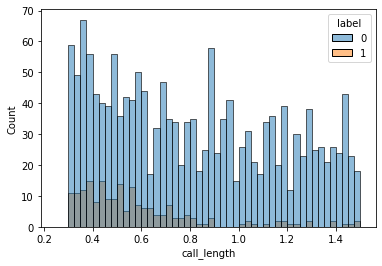

In [218]:
sns.histplot(model_annot_train_df[['label', 'call_length']].reset_index(drop=True), x='call_length', hue='label', binrange=(0.25, 1.5) ,bins=50)
plt.show()